In [1]:
from glob import glob
import os
import itertools
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from mpl_toolkits.axes_grid1 import ImageGrid, make_axes_locatable, host_subplot
import matplotlib.ticker as ticker
from matplotlib.collections import Collection, LineCollection
from matplotlib.artist import allow_rasterization
from matplotlib.font_manager import FontProperties
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.dates as md
import matplotlib.ticker as ticker
from metpy.plots import ctables
#from pyPIPS import disdrometer_module as dis
from pyPIPS import pips_io as pipsio
from pyPIPS import timemodule as tm
from pyPIPS.utils import mtokm, getTimeWindow, interp_along_1D
from pyPIPS import plotmodule as pm
from pyPIPS import PIPS as pips
from pyPIPS import fmcw
from itertools import cycle
import netCDF4 as netcdf
from datetime import datetime, timedelta
import pandas as pd
import xarray as xr
from skimage.restoration import unwrap_phase
import skimage.feature as SF
import numpy.ma as ma
from scipy import ndimage, interpolate
import pyart
import cartopy.crs as ccrs
%load_ext autoreload
%autoreload 2
%matplotlib inline


## You are using the Python ARM Radar Toolkit (Py-ART), an open source
## library for working with weather radar data. Py-ART is partly
## supported by the U.S. Department of Energy as part of the Atmospheric
## Radiation Measurement (ARM) Climate Research Facility, an Office of
## Science user facility.
##
## If you use this software to prepare a publication, please cite:
##
##     JJ Helmus and SM Collis, JORS 2016, doi: 10.5334/jors.119



In [2]:
# Read in PIPS data
PIPS_data_dir = '/Users/terrell8/sshfs_mounts/depot/data/Projects/VORTEXSE/obsdata/full_PIPS_dataset/'
PIPS_filename = 'parsivel_combined_FMCW_2017_032717_PIPS2A_60s.nc'
PIPS_filepath = os.path.join(PIPS_data_dir, PIPS_filename)
PIPS_ds = xr.open_dataset(PIPS_filepath)
print(PIPS_ds)

<xarray.Dataset>
Dimensions:                  (diameter_bin: 32, fallspeed_bin: 32, parameter: 3, time: 1441)
Coordinates:
  * time                     (time) datetime64[ns] 2017-03-27 ... 2017-03-28
    fallspeed                (fallspeed_bin) float64 ...
    diameter                 (diameter_bin) float64 ...
    min_diameter             (diameter_bin) float64 ...
    max_diameter             (diameter_bin) float64 ...
    min_fallspeeds           (fallspeed_bin) float64 ...
    max_fallspeeds           (fallspeed_bin) float64 ...
  * parameter                (parameter) object 'N0' 'lamda' 'alpha'
Dimensions without coordinates: diameter_bin, fallspeed_bin
Data variables:
    precipintensity          (time) float64 ...
    precipaccum              (time) float64 ...
    parsivel_dBZ             (time) float64 ...
    pcount                   (time) int64 ...
    signal_amplitude         (time) float64 ...
    pvoltage                 (time) float64 ...
    sensor_temp              (

/Users/terrell8/miniconda2/envs/pyPIPS/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/Users/terrell8/miniconda2/envs/pyPIPS/lib/python3.8/site-packages/xarray/backends/netCDF4_.py:378: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  attributes = {k: var.getncattr(k) for k in var.ncattrs()}
/Users/terrell8/miniconda2/envs/pyPIPS/lib/python3.8/site-packages/xarray/backends/netCDF4_.py:378: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  attributes = {k: var.getncattr(k) for k in var.ncattrs()}
/Users/terrell8/miniconda2/envs/pyPIPS/lib/python3.8/site-packages/xarray/backends/netCDF4_.py:378: DeprecationWarning: tostring() is deprecated. Use tobytes() 

In [3]:
radar_starttimestamp = '201703271900'
radar_endtimestamp = '201703280356'

radar_startdatetime = datetime.strptime(radar_starttimestamp, '%Y%m%d%H%M')
radar_enddatetime = datetime.strptime(radar_endtimestamp, '%Y%m%d%H%M')

radar_basedir = \
    '/Users/terrell8/sshfs_mounts/depot/data/Projects/VORTEXSE/obsdata/2017/NEXRAD/IOP_1B'
level2_dir = os.path.join(radar_basedir, 'level2')
level2_files = sorted(glob(level2_dir + '/*.ar2v'))

level2_files_to_read = []
for level2_file in level2_files:
    radar_file_timestamp = os.path.basename(level2_file)[4:19]
    radar_file_datetime = datetime.strptime(radar_file_timestamp, '%Y%m%d_%H%M%S')
    if radar_file_datetime >= radar_startdatetime and radar_file_datetime <= radar_enddatetime:
        level2_files_to_read.append(level2_file)
        print(os.path.basename(level2_file))

gridded_output_dir = os.path.join(radar_basedir, 'gridded_new')
if not os.path.exists(gridded_output_dir):
    os.makedirs(gridded_output_dir)

KGWX20170327_190247_V06.ar2v
KGWX20170327_190808_V06.ar2v
KGWX20170327_191330_V06.ar2v
KGWX20170327_191858_V06.ar2v
KGWX20170327_192426_V06.ar2v
KGWX20170327_192941_V06.ar2v
KGWX20170327_193508_V06.ar2v
KGWX20170327_194032_V06.ar2v
KGWX20170327_194540_V06.ar2v
KGWX20170327_195101_V06.ar2v
KGWX20170327_195623_V06.ar2v
KGWX20170327_200151_V06.ar2v
KGWX20170327_200719_V06.ar2v
KGWX20170327_201248_V06.ar2v
KGWX20170327_201816_V06.ar2v
KGWX20170327_202330_V06.ar2v
KGWX20170327_202845_V06.ar2v
KGWX20170327_203405_V06.ar2v
KGWX20170327_203927_V06.ar2v
KGWX20170327_204441_V06.ar2v
KGWX20170327_204955_V06.ar2v
KGWX20170327_205524_V06.ar2v
KGWX20170327_210052_V06.ar2v
KGWX20170327_210619_V06.ar2v
KGWX20170327_211148_V06.ar2v
KGWX20170327_211656_V06.ar2v
KGWX20170327_212210_V06.ar2v
KGWX20170327_212732_V06.ar2v
KGWX20170327_213253_V06.ar2v
KGWX20170327_213813_V06.ar2v
KGWX20170327_214335_V06.ar2v
KGWX20170327_214856_V06.ar2v
KGWX20170327_215426_V06.ar2v
KGWX20170327_215954_V06.ar2v
KGWX20170327_2

/Users/terrell8/miniconda2/envs/pyPIPS/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [4]:
# Set up grid limits and spacing

xmin = -123000.
xmax = 123000.
dx = 1000.
nx = int((xmax - xmin) / dx) + 1

ymin = -123000.
ymax = 123000.
dy = 1000.
ny = int((ymax - ymin) / dy) + 1

zmin = 500.
zmax = 4500.
dz = 100.
nz = int((zmax - zmin) / dz) + 1
print(nz)

41


/Users/terrell8/miniconda2/envs/pyPIPS/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [5]:
# Test first radar file

print(level2_files_to_read[0])

radar = pyart.io.read_nexrad_archive(level2_files_to_read[0])

grid = pyart.map.grid_from_radars(
    (radar,),
    grid_shape=(nz, ny, nx),
    grid_limits=((zmin, zmax), (ymin, ymax), (xmin, xmax)),
    fields=['differential_reflectivity', 'reflectivity', 'cross_correlation_ratio'],
    weighting_function='Barnes2')

grid_xr = grid.to_xarray()
print(grid_xr)

/Users/terrell8/miniconda2/envs/pyPIPS/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


/Users/terrell8/sshfs_mounts/depot/data/Projects/VORTEXSE/obsdata/2017/NEXRAD/IOP_1B/level2/KGWX20170327_190247_V06.ar2v


/Users/terrell8/miniconda2/envs/pyPIPS/lib/python3.8/site-packages/pyart/filters/gatefilter.py:460: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  self._gate_excluded = np.zeros(shape, dtype=np.bool)


<xarray.Dataset>
Dimensions:                    (time: 1, x: 247, y: 247, z: 41)
Coordinates:
  * time                       (time) object 2017-03-27 19:02:47.533000
  * z                          (z) float64 500.0 600.0 700.0 ... 4.4e+03 4.5e+03
    lat                        (y) float64 32.78 32.79 32.8 ... 34.98 34.99 35.0
    lon                        (x) float64 -89.64 -89.63 ... -87.02 -87.01
  * y                          (y) float64 -1.23e+05 -1.22e+05 ... 1.23e+05
  * x                          (x) float64 -1.23e+05 -1.22e+05 ... 1.23e+05
Data variables:
    differential_reflectivity  (time, z, y, x) float32 1.61 1.648 ... nan nan
    reflectivity               (time, z, y, x) float32 11.33 12.01 ... nan nan
    cross_correlation_ratio    (time, z, y, x) float32 1.011 1.01 ... nan nan
    ROI                        (time, z, y, x) float32 4.58e+03 ... 4.78e+03


/Users/terrell8/miniconda2/envs/pyPIPS/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


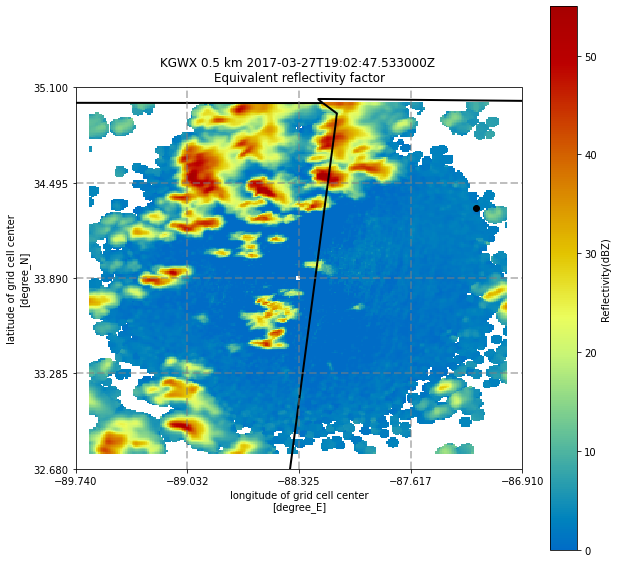

In [6]:
display = pyart.graph.GridMapDisplay(grid)

# create the plot
projection = ccrs.PlateCarree()
fig = plt.figure(figsize=(10,10))
ax = plt.axes(projection=projection)

#ax.imshow(grid.fields['REF']['data'][0], origin='lower')
display.plot_grid('reflectivity', 0, vmin=0, vmax=55, projection=projection, cmap="pyart_HomeyerRainbow", ax=ax)
#plt.xlim(-86.7, -85.3)
#plt.ylim(34.0, 36.0)
#start_time = '2017-04-30T20:45'
#end_time = '2017-04-30T20:45'
#plt.title('HTX Time {}'.format(start_time))

# Read in the file, create a RadarMapDisplay object
# fmcw_data_dir = '/Users/terrell8/sshfs_mounts/depot/data/Projects/VORTEXSE/obsdata/2017/FMCW/0430'

# Indicate the radar location with a point
FMCW_lat = 34.3352
FMCW_lon = -87.2024
ax.plot([FMCW_lon], [FMCW_lat], color='black', marker='o', transform=ccrs.PlateCarree())


In [7]:
# Create gridded radar objects and dump to disk
for i, f in enumerate(level2_files_to_read):
    print("On file {:d} of {:d} ({:.2f}%)".format(i+1, len(level2_files), (i+1)/len(level2_files)*100.))
    print("Reading {}".format(os.path.basename(f)))
    radar = pyart.io.read_nexrad_archive(f)
    output_file = os.path.basename(f)[:-5]+"_gridded.nc"
    output_path = os.path.join(gridded_output_dir, output_file)
    
    print("Mapping to grid!")
    grid = pyart.map.grid_from_radars(
        (radar,),
        grid_shape=(nz, ny, nx),
        grid_limits=((zmin, zmax), (ymin, ymax), (xmin, xmax)),
        fields=['differential_reflectivity', 'reflectivity', 'cross_correlation_ratio'],
        weighting_function='Barnes2')
    print("Writing {}".format(output_file))
    pyart.io.write_grid(output_path, grid, arm_time_variables=True, arm_alt_lat_lon_variables=True, 
                        write_point_x_y_z=True, write_point_lon_lat_alt=True)


/Users/terrell8/miniconda2/envs/pyPIPS/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


On file 1 of 110 (0.91%)
Reading KGWX20170327_190247_V06.ar2v
Mapping to grid!


/Users/terrell8/miniconda2/envs/pyPIPS/lib/python3.8/site-packages/pyart/filters/gatefilter.py:460: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  self._gate_excluded = np.zeros(shape, dtype=np.bool)


Writing KGWX20170327_190247_V06_gridded.nc


/Users/terrell8/miniconda2/envs/pyPIPS/lib/python3.8/site-packages/pyart/io/common.py:71: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  carr = netCDF4.stringtochar(arr)


On file 2 of 110 (1.82%)
Reading KGWX20170327_190808_V06.ar2v
Mapping to grid!


/Users/terrell8/miniconda2/envs/pyPIPS/lib/python3.8/site-packages/pyart/filters/gatefilter.py:460: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  self._gate_excluded = np.zeros(shape, dtype=np.bool)


Writing KGWX20170327_190808_V06_gridded.nc


/Users/terrell8/miniconda2/envs/pyPIPS/lib/python3.8/site-packages/pyart/io/common.py:71: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  carr = netCDF4.stringtochar(arr)


On file 3 of 110 (2.73%)
Reading KGWX20170327_191330_V06.ar2v
Mapping to grid!


/Users/terrell8/miniconda2/envs/pyPIPS/lib/python3.8/site-packages/pyart/filters/gatefilter.py:460: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  self._gate_excluded = np.zeros(shape, dtype=np.bool)


Writing KGWX20170327_191330_V06_gridded.nc


/Users/terrell8/miniconda2/envs/pyPIPS/lib/python3.8/site-packages/pyart/io/common.py:71: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  carr = netCDF4.stringtochar(arr)


On file 4 of 110 (3.64%)
Reading KGWX20170327_191858_V06.ar2v
Mapping to grid!


/Users/terrell8/miniconda2/envs/pyPIPS/lib/python3.8/site-packages/pyart/filters/gatefilter.py:460: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  self._gate_excluded = np.zeros(shape, dtype=np.bool)


Writing KGWX20170327_191858_V06_gridded.nc


/Users/terrell8/miniconda2/envs/pyPIPS/lib/python3.8/site-packages/pyart/io/common.py:71: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  carr = netCDF4.stringtochar(arr)


On file 5 of 110 (4.55%)
Reading KGWX20170327_192426_V06.ar2v
Mapping to grid!


/Users/terrell8/miniconda2/envs/pyPIPS/lib/python3.8/site-packages/pyart/filters/gatefilter.py:460: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  self._gate_excluded = np.zeros(shape, dtype=np.bool)


Writing KGWX20170327_192426_V06_gridded.nc


/Users/terrell8/miniconda2/envs/pyPIPS/lib/python3.8/site-packages/pyart/io/common.py:71: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  carr = netCDF4.stringtochar(arr)


On file 6 of 110 (5.45%)
Reading KGWX20170327_192941_V06.ar2v
Mapping to grid!


/Users/terrell8/miniconda2/envs/pyPIPS/lib/python3.8/site-packages/pyart/filters/gatefilter.py:460: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  self._gate_excluded = np.zeros(shape, dtype=np.bool)


Writing KGWX20170327_192941_V06_gridded.nc


/Users/terrell8/miniconda2/envs/pyPIPS/lib/python3.8/site-packages/pyart/io/common.py:71: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  carr = netCDF4.stringtochar(arr)


On file 7 of 110 (6.36%)
Reading KGWX20170327_193508_V06.ar2v
Mapping to grid!


/Users/terrell8/miniconda2/envs/pyPIPS/lib/python3.8/site-packages/pyart/filters/gatefilter.py:460: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  self._gate_excluded = np.zeros(shape, dtype=np.bool)


Writing KGWX20170327_193508_V06_gridded.nc


/Users/terrell8/miniconda2/envs/pyPIPS/lib/python3.8/site-packages/pyart/io/common.py:71: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  carr = netCDF4.stringtochar(arr)


On file 8 of 110 (7.27%)
Reading KGWX20170327_194032_V06.ar2v
Mapping to grid!


/Users/terrell8/miniconda2/envs/pyPIPS/lib/python3.8/site-packages/pyart/filters/gatefilter.py:460: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  self._gate_excluded = np.zeros(shape, dtype=np.bool)


Writing KGWX20170327_194032_V06_gridded.nc


/Users/terrell8/miniconda2/envs/pyPIPS/lib/python3.8/site-packages/pyart/io/common.py:71: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  carr = netCDF4.stringtochar(arr)


On file 9 of 110 (8.18%)
Reading KGWX20170327_194540_V06.ar2v
Mapping to grid!


/Users/terrell8/miniconda2/envs/pyPIPS/lib/python3.8/site-packages/pyart/filters/gatefilter.py:460: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  self._gate_excluded = np.zeros(shape, dtype=np.bool)


Writing KGWX20170327_194540_V06_gridded.nc


/Users/terrell8/miniconda2/envs/pyPIPS/lib/python3.8/site-packages/pyart/io/common.py:71: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  carr = netCDF4.stringtochar(arr)


On file 10 of 110 (9.09%)
Reading KGWX20170327_195101_V06.ar2v
Mapping to grid!


/Users/terrell8/miniconda2/envs/pyPIPS/lib/python3.8/site-packages/pyart/filters/gatefilter.py:460: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  self._gate_excluded = np.zeros(shape, dtype=np.bool)


Writing KGWX20170327_195101_V06_gridded.nc


/Users/terrell8/miniconda2/envs/pyPIPS/lib/python3.8/site-packages/pyart/io/common.py:71: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  carr = netCDF4.stringtochar(arr)


On file 11 of 110 (10.00%)
Reading KGWX20170327_195623_V06.ar2v
Mapping to grid!


/Users/terrell8/miniconda2/envs/pyPIPS/lib/python3.8/site-packages/pyart/filters/gatefilter.py:460: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  self._gate_excluded = np.zeros(shape, dtype=np.bool)


Writing KGWX20170327_195623_V06_gridded.nc


/Users/terrell8/miniconda2/envs/pyPIPS/lib/python3.8/site-packages/pyart/io/common.py:71: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  carr = netCDF4.stringtochar(arr)


On file 12 of 110 (10.91%)
Reading KGWX20170327_200151_V06.ar2v
Mapping to grid!


/Users/terrell8/miniconda2/envs/pyPIPS/lib/python3.8/site-packages/pyart/filters/gatefilter.py:460: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  self._gate_excluded = np.zeros(shape, dtype=np.bool)


Writing KGWX20170327_200151_V06_gridded.nc


/Users/terrell8/miniconda2/envs/pyPIPS/lib/python3.8/site-packages/pyart/io/common.py:71: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  carr = netCDF4.stringtochar(arr)


On file 13 of 110 (11.82%)
Reading KGWX20170327_200719_V06.ar2v
Mapping to grid!


/Users/terrell8/miniconda2/envs/pyPIPS/lib/python3.8/site-packages/pyart/filters/gatefilter.py:460: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  self._gate_excluded = np.zeros(shape, dtype=np.bool)


Writing KGWX20170327_200719_V06_gridded.nc


/Users/terrell8/miniconda2/envs/pyPIPS/lib/python3.8/site-packages/pyart/io/common.py:71: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  carr = netCDF4.stringtochar(arr)


On file 14 of 110 (12.73%)
Reading KGWX20170327_201248_V06.ar2v
Mapping to grid!


/Users/terrell8/miniconda2/envs/pyPIPS/lib/python3.8/site-packages/pyart/filters/gatefilter.py:460: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  self._gate_excluded = np.zeros(shape, dtype=np.bool)


Writing KGWX20170327_201248_V06_gridded.nc


/Users/terrell8/miniconda2/envs/pyPIPS/lib/python3.8/site-packages/pyart/io/common.py:71: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  carr = netCDF4.stringtochar(arr)


On file 15 of 110 (13.64%)
Reading KGWX20170327_201816_V06.ar2v
Mapping to grid!


/Users/terrell8/miniconda2/envs/pyPIPS/lib/python3.8/site-packages/pyart/filters/gatefilter.py:460: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  self._gate_excluded = np.zeros(shape, dtype=np.bool)


Writing KGWX20170327_201816_V06_gridded.nc


/Users/terrell8/miniconda2/envs/pyPIPS/lib/python3.8/site-packages/pyart/io/common.py:71: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  carr = netCDF4.stringtochar(arr)


On file 16 of 110 (14.55%)
Reading KGWX20170327_202330_V06.ar2v
Mapping to grid!


/Users/terrell8/miniconda2/envs/pyPIPS/lib/python3.8/site-packages/pyart/filters/gatefilter.py:460: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  self._gate_excluded = np.zeros(shape, dtype=np.bool)


Writing KGWX20170327_202330_V06_gridded.nc


/Users/terrell8/miniconda2/envs/pyPIPS/lib/python3.8/site-packages/pyart/io/common.py:71: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  carr = netCDF4.stringtochar(arr)


On file 17 of 110 (15.45%)
Reading KGWX20170327_202845_V06.ar2v
Mapping to grid!


/Users/terrell8/miniconda2/envs/pyPIPS/lib/python3.8/site-packages/pyart/filters/gatefilter.py:460: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  self._gate_excluded = np.zeros(shape, dtype=np.bool)


Writing KGWX20170327_202845_V06_gridded.nc


/Users/terrell8/miniconda2/envs/pyPIPS/lib/python3.8/site-packages/pyart/io/common.py:71: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  carr = netCDF4.stringtochar(arr)


On file 18 of 110 (16.36%)
Reading KGWX20170327_203405_V06.ar2v
Mapping to grid!


/Users/terrell8/miniconda2/envs/pyPIPS/lib/python3.8/site-packages/pyart/filters/gatefilter.py:460: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  self._gate_excluded = np.zeros(shape, dtype=np.bool)


Writing KGWX20170327_203405_V06_gridded.nc


/Users/terrell8/miniconda2/envs/pyPIPS/lib/python3.8/site-packages/pyart/io/common.py:71: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  carr = netCDF4.stringtochar(arr)


On file 19 of 110 (17.27%)
Reading KGWX20170327_203927_V06.ar2v
Mapping to grid!


/Users/terrell8/miniconda2/envs/pyPIPS/lib/python3.8/site-packages/pyart/filters/gatefilter.py:460: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  self._gate_excluded = np.zeros(shape, dtype=np.bool)


Writing KGWX20170327_203927_V06_gridded.nc


/Users/terrell8/miniconda2/envs/pyPIPS/lib/python3.8/site-packages/pyart/io/common.py:71: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  carr = netCDF4.stringtochar(arr)


On file 20 of 110 (18.18%)
Reading KGWX20170327_204441_V06.ar2v
Mapping to grid!


/Users/terrell8/miniconda2/envs/pyPIPS/lib/python3.8/site-packages/pyart/filters/gatefilter.py:460: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  self._gate_excluded = np.zeros(shape, dtype=np.bool)


Writing KGWX20170327_204441_V06_gridded.nc


/Users/terrell8/miniconda2/envs/pyPIPS/lib/python3.8/site-packages/pyart/io/common.py:71: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  carr = netCDF4.stringtochar(arr)


On file 21 of 110 (19.09%)
Reading KGWX20170327_204955_V06.ar2v
Mapping to grid!


/Users/terrell8/miniconda2/envs/pyPIPS/lib/python3.8/site-packages/pyart/filters/gatefilter.py:460: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  self._gate_excluded = np.zeros(shape, dtype=np.bool)


Writing KGWX20170327_204955_V06_gridded.nc


/Users/terrell8/miniconda2/envs/pyPIPS/lib/python3.8/site-packages/pyart/io/common.py:71: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  carr = netCDF4.stringtochar(arr)


On file 22 of 110 (20.00%)
Reading KGWX20170327_205524_V06.ar2v
Mapping to grid!


/Users/terrell8/miniconda2/envs/pyPIPS/lib/python3.8/site-packages/pyart/filters/gatefilter.py:460: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  self._gate_excluded = np.zeros(shape, dtype=np.bool)


Writing KGWX20170327_205524_V06_gridded.nc


/Users/terrell8/miniconda2/envs/pyPIPS/lib/python3.8/site-packages/pyart/io/common.py:71: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  carr = netCDF4.stringtochar(arr)


On file 23 of 110 (20.91%)
Reading KGWX20170327_210052_V06.ar2v
Mapping to grid!


/Users/terrell8/miniconda2/envs/pyPIPS/lib/python3.8/site-packages/pyart/filters/gatefilter.py:460: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  self._gate_excluded = np.zeros(shape, dtype=np.bool)


Writing KGWX20170327_210052_V06_gridded.nc


/Users/terrell8/miniconda2/envs/pyPIPS/lib/python3.8/site-packages/pyart/io/common.py:71: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  carr = netCDF4.stringtochar(arr)


On file 24 of 110 (21.82%)
Reading KGWX20170327_210619_V06.ar2v
Mapping to grid!


/Users/terrell8/miniconda2/envs/pyPIPS/lib/python3.8/site-packages/pyart/filters/gatefilter.py:460: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  self._gate_excluded = np.zeros(shape, dtype=np.bool)


Writing KGWX20170327_210619_V06_gridded.nc


/Users/terrell8/miniconda2/envs/pyPIPS/lib/python3.8/site-packages/pyart/io/common.py:71: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  carr = netCDF4.stringtochar(arr)


On file 25 of 110 (22.73%)
Reading KGWX20170327_211148_V06.ar2v
Mapping to grid!


/Users/terrell8/miniconda2/envs/pyPIPS/lib/python3.8/site-packages/pyart/filters/gatefilter.py:460: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  self._gate_excluded = np.zeros(shape, dtype=np.bool)


Writing KGWX20170327_211148_V06_gridded.nc


/Users/terrell8/miniconda2/envs/pyPIPS/lib/python3.8/site-packages/pyart/io/common.py:71: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  carr = netCDF4.stringtochar(arr)


On file 26 of 110 (23.64%)
Reading KGWX20170327_211656_V06.ar2v
Mapping to grid!


/Users/terrell8/miniconda2/envs/pyPIPS/lib/python3.8/site-packages/pyart/filters/gatefilter.py:460: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  self._gate_excluded = np.zeros(shape, dtype=np.bool)


Writing KGWX20170327_211656_V06_gridded.nc


/Users/terrell8/miniconda2/envs/pyPIPS/lib/python3.8/site-packages/pyart/io/common.py:71: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  carr = netCDF4.stringtochar(arr)


On file 27 of 110 (24.55%)
Reading KGWX20170327_212210_V06.ar2v
Mapping to grid!


/Users/terrell8/miniconda2/envs/pyPIPS/lib/python3.8/site-packages/pyart/filters/gatefilter.py:460: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  self._gate_excluded = np.zeros(shape, dtype=np.bool)


Writing KGWX20170327_212210_V06_gridded.nc


/Users/terrell8/miniconda2/envs/pyPIPS/lib/python3.8/site-packages/pyart/io/common.py:71: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  carr = netCDF4.stringtochar(arr)


On file 28 of 110 (25.45%)
Reading KGWX20170327_212732_V06.ar2v
Mapping to grid!


/Users/terrell8/miniconda2/envs/pyPIPS/lib/python3.8/site-packages/pyart/filters/gatefilter.py:460: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  self._gate_excluded = np.zeros(shape, dtype=np.bool)


Writing KGWX20170327_212732_V06_gridded.nc


/Users/terrell8/miniconda2/envs/pyPIPS/lib/python3.8/site-packages/pyart/io/common.py:71: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  carr = netCDF4.stringtochar(arr)


On file 29 of 110 (26.36%)
Reading KGWX20170327_213253_V06.ar2v
Mapping to grid!


/Users/terrell8/miniconda2/envs/pyPIPS/lib/python3.8/site-packages/pyart/filters/gatefilter.py:460: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  self._gate_excluded = np.zeros(shape, dtype=np.bool)


Writing KGWX20170327_213253_V06_gridded.nc


/Users/terrell8/miniconda2/envs/pyPIPS/lib/python3.8/site-packages/pyart/io/common.py:71: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  carr = netCDF4.stringtochar(arr)


On file 30 of 110 (27.27%)
Reading KGWX20170327_213813_V06.ar2v
Mapping to grid!


/Users/terrell8/miniconda2/envs/pyPIPS/lib/python3.8/site-packages/pyart/filters/gatefilter.py:460: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  self._gate_excluded = np.zeros(shape, dtype=np.bool)


Writing KGWX20170327_213813_V06_gridded.nc


/Users/terrell8/miniconda2/envs/pyPIPS/lib/python3.8/site-packages/pyart/io/common.py:71: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  carr = netCDF4.stringtochar(arr)


On file 31 of 110 (28.18%)
Reading KGWX20170327_214335_V06.ar2v
Mapping to grid!


/Users/terrell8/miniconda2/envs/pyPIPS/lib/python3.8/site-packages/pyart/filters/gatefilter.py:460: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  self._gate_excluded = np.zeros(shape, dtype=np.bool)


Writing KGWX20170327_214335_V06_gridded.nc


/Users/terrell8/miniconda2/envs/pyPIPS/lib/python3.8/site-packages/pyart/io/common.py:71: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  carr = netCDF4.stringtochar(arr)


On file 32 of 110 (29.09%)
Reading KGWX20170327_214856_V06.ar2v
Mapping to grid!


/Users/terrell8/miniconda2/envs/pyPIPS/lib/python3.8/site-packages/pyart/filters/gatefilter.py:460: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  self._gate_excluded = np.zeros(shape, dtype=np.bool)


Writing KGWX20170327_214856_V06_gridded.nc


/Users/terrell8/miniconda2/envs/pyPIPS/lib/python3.8/site-packages/pyart/io/common.py:71: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  carr = netCDF4.stringtochar(arr)


On file 33 of 110 (30.00%)
Reading KGWX20170327_215426_V06.ar2v
Mapping to grid!


/Users/terrell8/miniconda2/envs/pyPIPS/lib/python3.8/site-packages/pyart/filters/gatefilter.py:460: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  self._gate_excluded = np.zeros(shape, dtype=np.bool)


Writing KGWX20170327_215426_V06_gridded.nc


/Users/terrell8/miniconda2/envs/pyPIPS/lib/python3.8/site-packages/pyart/io/common.py:71: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  carr = netCDF4.stringtochar(arr)


On file 34 of 110 (30.91%)
Reading KGWX20170327_215954_V06.ar2v
Mapping to grid!


/Users/terrell8/miniconda2/envs/pyPIPS/lib/python3.8/site-packages/pyart/filters/gatefilter.py:460: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  self._gate_excluded = np.zeros(shape, dtype=np.bool)


Writing KGWX20170327_215954_V06_gridded.nc


/Users/terrell8/miniconda2/envs/pyPIPS/lib/python3.8/site-packages/pyart/io/common.py:71: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  carr = netCDF4.stringtochar(arr)


On file 35 of 110 (31.82%)
Reading KGWX20170327_220508_V06.ar2v
Mapping to grid!


/Users/terrell8/miniconda2/envs/pyPIPS/lib/python3.8/site-packages/pyart/filters/gatefilter.py:460: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  self._gate_excluded = np.zeros(shape, dtype=np.bool)


Writing KGWX20170327_220508_V06_gridded.nc


/Users/terrell8/miniconda2/envs/pyPIPS/lib/python3.8/site-packages/pyart/io/common.py:71: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  carr = netCDF4.stringtochar(arr)


On file 36 of 110 (32.73%)
Reading KGWX20170327_221036_V06.ar2v
Mapping to grid!


/Users/terrell8/miniconda2/envs/pyPIPS/lib/python3.8/site-packages/pyart/filters/gatefilter.py:460: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  self._gate_excluded = np.zeros(shape, dtype=np.bool)


Writing KGWX20170327_221036_V06_gridded.nc


/Users/terrell8/miniconda2/envs/pyPIPS/lib/python3.8/site-packages/pyart/io/common.py:71: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  carr = netCDF4.stringtochar(arr)


On file 37 of 110 (33.64%)
Reading KGWX20170327_221550_V06.ar2v
Mapping to grid!


/Users/terrell8/miniconda2/envs/pyPIPS/lib/python3.8/site-packages/pyart/filters/gatefilter.py:460: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  self._gate_excluded = np.zeros(shape, dtype=np.bool)


Writing KGWX20170327_221550_V06_gridded.nc


/Users/terrell8/miniconda2/envs/pyPIPS/lib/python3.8/site-packages/pyart/io/common.py:71: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  carr = netCDF4.stringtochar(arr)


On file 38 of 110 (34.55%)
Reading KGWX20170327_222117_V06.ar2v
Mapping to grid!


/Users/terrell8/miniconda2/envs/pyPIPS/lib/python3.8/site-packages/pyart/filters/gatefilter.py:460: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  self._gate_excluded = np.zeros(shape, dtype=np.bool)


Writing KGWX20170327_222117_V06_gridded.nc


/Users/terrell8/miniconda2/envs/pyPIPS/lib/python3.8/site-packages/pyart/io/common.py:71: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  carr = netCDF4.stringtochar(arr)


On file 39 of 110 (35.45%)
Reading KGWX20170327_222631_V06.ar2v
Mapping to grid!


/Users/terrell8/miniconda2/envs/pyPIPS/lib/python3.8/site-packages/pyart/filters/gatefilter.py:460: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  self._gate_excluded = np.zeros(shape, dtype=np.bool)


Writing KGWX20170327_222631_V06_gridded.nc


/Users/terrell8/miniconda2/envs/pyPIPS/lib/python3.8/site-packages/pyart/io/common.py:71: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  carr = netCDF4.stringtochar(arr)


On file 40 of 110 (36.36%)
Reading KGWX20170327_223125_V06.ar2v
Mapping to grid!


/Users/terrell8/miniconda2/envs/pyPIPS/lib/python3.8/site-packages/pyart/filters/gatefilter.py:460: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  self._gate_excluded = np.zeros(shape, dtype=np.bool)


Writing KGWX20170327_223125_V06_gridded.nc


/Users/terrell8/miniconda2/envs/pyPIPS/lib/python3.8/site-packages/pyart/io/common.py:71: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  carr = netCDF4.stringtochar(arr)


On file 41 of 110 (37.27%)
Reading KGWX20170327_223618_V06.ar2v
Mapping to grid!


/Users/terrell8/miniconda2/envs/pyPIPS/lib/python3.8/site-packages/pyart/filters/gatefilter.py:460: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  self._gate_excluded = np.zeros(shape, dtype=np.bool)


Writing KGWX20170327_223618_V06_gridded.nc


/Users/terrell8/miniconda2/envs/pyPIPS/lib/python3.8/site-packages/pyart/io/common.py:71: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  carr = netCDF4.stringtochar(arr)


On file 42 of 110 (38.18%)
Reading KGWX20170327_224118_V06.ar2v
Mapping to grid!


/Users/terrell8/miniconda2/envs/pyPIPS/lib/python3.8/site-packages/pyart/filters/gatefilter.py:460: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  self._gate_excluded = np.zeros(shape, dtype=np.bool)


Writing KGWX20170327_224118_V06_gridded.nc


/Users/terrell8/miniconda2/envs/pyPIPS/lib/python3.8/site-packages/pyart/io/common.py:71: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  carr = netCDF4.stringtochar(arr)


On file 43 of 110 (39.09%)
Reading KGWX20170327_224612_V06.ar2v
Mapping to grid!


/Users/terrell8/miniconda2/envs/pyPIPS/lib/python3.8/site-packages/pyart/filters/gatefilter.py:460: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  self._gate_excluded = np.zeros(shape, dtype=np.bool)


Writing KGWX20170327_224612_V06_gridded.nc


/Users/terrell8/miniconda2/envs/pyPIPS/lib/python3.8/site-packages/pyart/io/common.py:71: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  carr = netCDF4.stringtochar(arr)


On file 44 of 110 (40.00%)
Reading KGWX20170327_225112_V06.ar2v
Mapping to grid!


/Users/terrell8/miniconda2/envs/pyPIPS/lib/python3.8/site-packages/pyart/filters/gatefilter.py:460: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  self._gate_excluded = np.zeros(shape, dtype=np.bool)


Writing KGWX20170327_225112_V06_gridded.nc


/Users/terrell8/miniconda2/envs/pyPIPS/lib/python3.8/site-packages/pyart/io/common.py:71: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  carr = netCDF4.stringtochar(arr)


On file 45 of 110 (40.91%)
Reading KGWX20170327_225552_V06.ar2v
Mapping to grid!


/Users/terrell8/miniconda2/envs/pyPIPS/lib/python3.8/site-packages/pyart/filters/gatefilter.py:460: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  self._gate_excluded = np.zeros(shape, dtype=np.bool)


Writing KGWX20170327_225552_V06_gridded.nc


/Users/terrell8/miniconda2/envs/pyPIPS/lib/python3.8/site-packages/pyart/io/common.py:71: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  carr = netCDF4.stringtochar(arr)


On file 46 of 110 (41.82%)
Reading KGWX20170327_230033_V06.ar2v
Mapping to grid!


/Users/terrell8/miniconda2/envs/pyPIPS/lib/python3.8/site-packages/pyart/filters/gatefilter.py:460: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  self._gate_excluded = np.zeros(shape, dtype=np.bool)


Writing KGWX20170327_230033_V06_gridded.nc


/Users/terrell8/miniconda2/envs/pyPIPS/lib/python3.8/site-packages/pyart/io/common.py:71: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  carr = netCDF4.stringtochar(arr)


On file 47 of 110 (42.73%)
Reading KGWX20170327_230513_V06.ar2v
Mapping to grid!


/Users/terrell8/miniconda2/envs/pyPIPS/lib/python3.8/site-packages/pyart/filters/gatefilter.py:460: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  self._gate_excluded = np.zeros(shape, dtype=np.bool)


Writing KGWX20170327_230513_V06_gridded.nc


/Users/terrell8/miniconda2/envs/pyPIPS/lib/python3.8/site-packages/pyart/io/common.py:71: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  carr = netCDF4.stringtochar(arr)


On file 48 of 110 (43.64%)
Reading KGWX20170327_230940_V06.ar2v
Mapping to grid!


/Users/terrell8/miniconda2/envs/pyPIPS/lib/python3.8/site-packages/pyart/filters/gatefilter.py:460: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  self._gate_excluded = np.zeros(shape, dtype=np.bool)


Writing KGWX20170327_230940_V06_gridded.nc


/Users/terrell8/miniconda2/envs/pyPIPS/lib/python3.8/site-packages/pyart/io/common.py:71: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  carr = netCDF4.stringtochar(arr)


On file 49 of 110 (44.55%)
Reading KGWX20170327_231407_V06.ar2v
Mapping to grid!


/Users/terrell8/miniconda2/envs/pyPIPS/lib/python3.8/site-packages/pyart/filters/gatefilter.py:460: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  self._gate_excluded = np.zeros(shape, dtype=np.bool)


Writing KGWX20170327_231407_V06_gridded.nc


/Users/terrell8/miniconda2/envs/pyPIPS/lib/python3.8/site-packages/pyart/io/common.py:71: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  carr = netCDF4.stringtochar(arr)


On file 50 of 110 (45.45%)
Reading KGWX20170327_231833_V06.ar2v
Mapping to grid!


/Users/terrell8/miniconda2/envs/pyPIPS/lib/python3.8/site-packages/pyart/filters/gatefilter.py:460: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  self._gate_excluded = np.zeros(shape, dtype=np.bool)


Writing KGWX20170327_231833_V06_gridded.nc


/Users/terrell8/miniconda2/envs/pyPIPS/lib/python3.8/site-packages/pyart/io/common.py:71: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  carr = netCDF4.stringtochar(arr)


On file 51 of 110 (46.36%)
Reading KGWX20170327_232246_V06.ar2v
Mapping to grid!


/Users/terrell8/miniconda2/envs/pyPIPS/lib/python3.8/site-packages/pyart/filters/gatefilter.py:460: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  self._gate_excluded = np.zeros(shape, dtype=np.bool)


Writing KGWX20170327_232246_V06_gridded.nc


/Users/terrell8/miniconda2/envs/pyPIPS/lib/python3.8/site-packages/pyart/io/common.py:71: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  carr = netCDF4.stringtochar(arr)


On file 52 of 110 (47.27%)
Reading KGWX20170327_232658_V06.ar2v
Mapping to grid!


/Users/terrell8/miniconda2/envs/pyPIPS/lib/python3.8/site-packages/pyart/filters/gatefilter.py:460: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  self._gate_excluded = np.zeros(shape, dtype=np.bool)


Writing KGWX20170327_232658_V06_gridded.nc


/Users/terrell8/miniconda2/envs/pyPIPS/lib/python3.8/site-packages/pyart/io/common.py:71: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  carr = netCDF4.stringtochar(arr)


On file 53 of 110 (48.18%)
Reading KGWX20170327_233111_V06.ar2v
Mapping to grid!


/Users/terrell8/miniconda2/envs/pyPIPS/lib/python3.8/site-packages/pyart/filters/gatefilter.py:460: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  self._gate_excluded = np.zeros(shape, dtype=np.bool)


Writing KGWX20170327_233111_V06_gridded.nc


/Users/terrell8/miniconda2/envs/pyPIPS/lib/python3.8/site-packages/pyart/io/common.py:71: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  carr = netCDF4.stringtochar(arr)


On file 54 of 110 (49.09%)
Reading KGWX20170327_233529_V06.ar2v
Mapping to grid!


/Users/terrell8/miniconda2/envs/pyPIPS/lib/python3.8/site-packages/pyart/filters/gatefilter.py:460: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  self._gate_excluded = np.zeros(shape, dtype=np.bool)


Writing KGWX20170327_233529_V06_gridded.nc


/Users/terrell8/miniconda2/envs/pyPIPS/lib/python3.8/site-packages/pyart/io/common.py:71: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  carr = netCDF4.stringtochar(arr)


On file 55 of 110 (50.00%)
Reading KGWX20170327_233941_V06.ar2v
Mapping to grid!


/Users/terrell8/miniconda2/envs/pyPIPS/lib/python3.8/site-packages/pyart/filters/gatefilter.py:460: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  self._gate_excluded = np.zeros(shape, dtype=np.bool)


Writing KGWX20170327_233941_V06_gridded.nc


/Users/terrell8/miniconda2/envs/pyPIPS/lib/python3.8/site-packages/pyart/io/common.py:71: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  carr = netCDF4.stringtochar(arr)


On file 56 of 110 (50.91%)
Reading KGWX20170327_234354_V06.ar2v
Mapping to grid!


/Users/terrell8/miniconda2/envs/pyPIPS/lib/python3.8/site-packages/pyart/filters/gatefilter.py:460: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  self._gate_excluded = np.zeros(shape, dtype=np.bool)


Writing KGWX20170327_234354_V06_gridded.nc


/Users/terrell8/miniconda2/envs/pyPIPS/lib/python3.8/site-packages/pyart/io/common.py:71: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  carr = netCDF4.stringtochar(arr)


On file 57 of 110 (51.82%)
Reading KGWX20170327_234753_V06.ar2v
Mapping to grid!


/Users/terrell8/miniconda2/envs/pyPIPS/lib/python3.8/site-packages/pyart/filters/gatefilter.py:460: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  self._gate_excluded = np.zeros(shape, dtype=np.bool)


Writing KGWX20170327_234753_V06_gridded.nc


/Users/terrell8/miniconda2/envs/pyPIPS/lib/python3.8/site-packages/pyart/io/common.py:71: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  carr = netCDF4.stringtochar(arr)


On file 58 of 110 (52.73%)
Reading KGWX20170327_235152_V06.ar2v
Mapping to grid!


/Users/terrell8/miniconda2/envs/pyPIPS/lib/python3.8/site-packages/pyart/filters/gatefilter.py:460: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  self._gate_excluded = np.zeros(shape, dtype=np.bool)


Writing KGWX20170327_235152_V06_gridded.nc


/Users/terrell8/miniconda2/envs/pyPIPS/lib/python3.8/site-packages/pyart/io/common.py:71: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  carr = netCDF4.stringtochar(arr)


On file 59 of 110 (53.64%)
Reading KGWX20170327_235552_V06.ar2v
Mapping to grid!


/Users/terrell8/miniconda2/envs/pyPIPS/lib/python3.8/site-packages/pyart/filters/gatefilter.py:460: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  self._gate_excluded = np.zeros(shape, dtype=np.bool)


Writing KGWX20170327_235552_V06_gridded.nc


/Users/terrell8/miniconda2/envs/pyPIPS/lib/python3.8/site-packages/pyart/io/common.py:71: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  carr = netCDF4.stringtochar(arr)


On file 60 of 110 (54.55%)
Reading KGWX20170327_235952_V06.ar2v
Mapping to grid!


/Users/terrell8/miniconda2/envs/pyPIPS/lib/python3.8/site-packages/pyart/filters/gatefilter.py:460: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  self._gate_excluded = np.zeros(shape, dtype=np.bool)


Writing KGWX20170327_235952_V06_gridded.nc


/Users/terrell8/miniconda2/envs/pyPIPS/lib/python3.8/site-packages/pyart/io/common.py:71: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  carr = netCDF4.stringtochar(arr)


On file 61 of 110 (55.45%)
Reading KGWX20170328_000351_V06.ar2v
Mapping to grid!


/Users/terrell8/miniconda2/envs/pyPIPS/lib/python3.8/site-packages/pyart/filters/gatefilter.py:460: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  self._gate_excluded = np.zeros(shape, dtype=np.bool)


Writing KGWX20170328_000351_V06_gridded.nc


/Users/terrell8/miniconda2/envs/pyPIPS/lib/python3.8/site-packages/pyart/io/common.py:71: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  carr = netCDF4.stringtochar(arr)


On file 62 of 110 (56.36%)
Reading KGWX20170328_000750_V06.ar2v
Mapping to grid!


/Users/terrell8/miniconda2/envs/pyPIPS/lib/python3.8/site-packages/pyart/filters/gatefilter.py:460: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  self._gate_excluded = np.zeros(shape, dtype=np.bool)


Writing KGWX20170328_000750_V06_gridded.nc


/Users/terrell8/miniconda2/envs/pyPIPS/lib/python3.8/site-packages/pyart/io/common.py:71: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  carr = netCDF4.stringtochar(arr)


On file 63 of 110 (57.27%)
Reading KGWX20170328_001148_V06.ar2v
Mapping to grid!


/Users/terrell8/miniconda2/envs/pyPIPS/lib/python3.8/site-packages/pyart/filters/gatefilter.py:460: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  self._gate_excluded = np.zeros(shape, dtype=np.bool)


Writing KGWX20170328_001148_V06_gridded.nc


/Users/terrell8/miniconda2/envs/pyPIPS/lib/python3.8/site-packages/pyart/io/common.py:71: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  carr = netCDF4.stringtochar(arr)


On file 64 of 110 (58.18%)
Reading KGWX20170328_001757_V06.ar2v
Mapping to grid!


/Users/terrell8/miniconda2/envs/pyPIPS/lib/python3.8/site-packages/pyart/filters/gatefilter.py:460: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  self._gate_excluded = np.zeros(shape, dtype=np.bool)


Writing KGWX20170328_001757_V06_gridded.nc


/Users/terrell8/miniconda2/envs/pyPIPS/lib/python3.8/site-packages/pyart/io/common.py:71: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  carr = netCDF4.stringtochar(arr)


On file 65 of 110 (59.09%)
Reading KGWX20170328_002156_V06.ar2v
Mapping to grid!


/Users/terrell8/miniconda2/envs/pyPIPS/lib/python3.8/site-packages/pyart/filters/gatefilter.py:460: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  self._gate_excluded = np.zeros(shape, dtype=np.bool)


Writing KGWX20170328_002156_V06_gridded.nc


/Users/terrell8/miniconda2/envs/pyPIPS/lib/python3.8/site-packages/pyart/io/common.py:71: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  carr = netCDF4.stringtochar(arr)


On file 66 of 110 (60.00%)
Reading KGWX20170328_002555_V06.ar2v
Mapping to grid!


/Users/terrell8/miniconda2/envs/pyPIPS/lib/python3.8/site-packages/pyart/filters/gatefilter.py:460: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  self._gate_excluded = np.zeros(shape, dtype=np.bool)


Writing KGWX20170328_002555_V06_gridded.nc


/Users/terrell8/miniconda2/envs/pyPIPS/lib/python3.8/site-packages/pyart/io/common.py:71: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  carr = netCDF4.stringtochar(arr)


On file 67 of 110 (60.91%)
Reading KGWX20170328_002954_V06.ar2v
Mapping to grid!


/Users/terrell8/miniconda2/envs/pyPIPS/lib/python3.8/site-packages/pyart/filters/gatefilter.py:460: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  self._gate_excluded = np.zeros(shape, dtype=np.bool)


Writing KGWX20170328_002954_V06_gridded.nc


/Users/terrell8/miniconda2/envs/pyPIPS/lib/python3.8/site-packages/pyart/io/common.py:71: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  carr = netCDF4.stringtochar(arr)


On file 68 of 110 (61.82%)
Reading KGWX20170328_003353_V06.ar2v
Mapping to grid!


/Users/terrell8/miniconda2/envs/pyPIPS/lib/python3.8/site-packages/pyart/filters/gatefilter.py:460: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  self._gate_excluded = np.zeros(shape, dtype=np.bool)


Writing KGWX20170328_003353_V06_gridded.nc


/Users/terrell8/miniconda2/envs/pyPIPS/lib/python3.8/site-packages/pyart/io/common.py:71: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  carr = netCDF4.stringtochar(arr)


On file 69 of 110 (62.73%)
Reading KGWX20170328_003753_V06.ar2v
Mapping to grid!


/Users/terrell8/miniconda2/envs/pyPIPS/lib/python3.8/site-packages/pyart/filters/gatefilter.py:460: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  self._gate_excluded = np.zeros(shape, dtype=np.bool)


Writing KGWX20170328_003753_V06_gridded.nc


/Users/terrell8/miniconda2/envs/pyPIPS/lib/python3.8/site-packages/pyart/io/common.py:71: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  carr = netCDF4.stringtochar(arr)


On file 70 of 110 (63.64%)
Reading KGWX20170328_004158_V06.ar2v
Mapping to grid!


/Users/terrell8/miniconda2/envs/pyPIPS/lib/python3.8/site-packages/pyart/filters/gatefilter.py:460: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  self._gate_excluded = np.zeros(shape, dtype=np.bool)


Writing KGWX20170328_004158_V06_gridded.nc


/Users/terrell8/miniconda2/envs/pyPIPS/lib/python3.8/site-packages/pyart/io/common.py:71: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  carr = netCDF4.stringtochar(arr)


On file 71 of 110 (64.55%)
Reading KGWX20170328_004631_V06.ar2v
Mapping to grid!


/Users/terrell8/miniconda2/envs/pyPIPS/lib/python3.8/site-packages/pyart/filters/gatefilter.py:460: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  self._gate_excluded = np.zeros(shape, dtype=np.bool)


Writing KGWX20170328_004631_V06_gridded.nc


/Users/terrell8/miniconda2/envs/pyPIPS/lib/python3.8/site-packages/pyart/io/common.py:71: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  carr = netCDF4.stringtochar(arr)


On file 72 of 110 (65.45%)
Reading KGWX20170328_005050_V06.ar2v
Mapping to grid!


/Users/terrell8/miniconda2/envs/pyPIPS/lib/python3.8/site-packages/pyart/filters/gatefilter.py:460: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  self._gate_excluded = np.zeros(shape, dtype=np.bool)


Writing KGWX20170328_005050_V06_gridded.nc


/Users/terrell8/miniconda2/envs/pyPIPS/lib/python3.8/site-packages/pyart/io/common.py:71: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  carr = netCDF4.stringtochar(arr)


On file 73 of 110 (66.36%)
Reading KGWX20170328_005455_V06.ar2v
Mapping to grid!


/Users/terrell8/miniconda2/envs/pyPIPS/lib/python3.8/site-packages/pyart/filters/gatefilter.py:460: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  self._gate_excluded = np.zeros(shape, dtype=np.bool)


Writing KGWX20170328_005455_V06_gridded.nc


/Users/terrell8/miniconda2/envs/pyPIPS/lib/python3.8/site-packages/pyart/io/common.py:71: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  carr = netCDF4.stringtochar(arr)


On file 74 of 110 (67.27%)
Reading KGWX20170328_005915_V06.ar2v
Mapping to grid!


/Users/terrell8/miniconda2/envs/pyPIPS/lib/python3.8/site-packages/pyart/filters/gatefilter.py:460: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  self._gate_excluded = np.zeros(shape, dtype=np.bool)


Writing KGWX20170328_005915_V06_gridded.nc


/Users/terrell8/miniconda2/envs/pyPIPS/lib/python3.8/site-packages/pyart/io/common.py:71: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  carr = netCDF4.stringtochar(arr)


On file 75 of 110 (68.18%)
Reading KGWX20170328_010327_V06.ar2v
Mapping to grid!


/Users/terrell8/miniconda2/envs/pyPIPS/lib/python3.8/site-packages/pyart/filters/gatefilter.py:460: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  self._gate_excluded = np.zeros(shape, dtype=np.bool)


Writing KGWX20170328_010327_V06_gridded.nc


/Users/terrell8/miniconda2/envs/pyPIPS/lib/python3.8/site-packages/pyart/io/common.py:71: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  carr = netCDF4.stringtochar(arr)


On file 76 of 110 (69.09%)
Reading KGWX20170328_010726_V06.ar2v
Mapping to grid!


/Users/terrell8/miniconda2/envs/pyPIPS/lib/python3.8/site-packages/pyart/filters/gatefilter.py:460: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  self._gate_excluded = np.zeros(shape, dtype=np.bool)


Writing KGWX20170328_010726_V06_gridded.nc


/Users/terrell8/miniconda2/envs/pyPIPS/lib/python3.8/site-packages/pyart/io/common.py:71: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  carr = netCDF4.stringtochar(arr)


On file 77 of 110 (70.00%)
Reading KGWX20170328_011138_V06.ar2v
Mapping to grid!


/Users/terrell8/miniconda2/envs/pyPIPS/lib/python3.8/site-packages/pyart/filters/gatefilter.py:460: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  self._gate_excluded = np.zeros(shape, dtype=np.bool)


Writing KGWX20170328_011138_V06_gridded.nc


/Users/terrell8/miniconda2/envs/pyPIPS/lib/python3.8/site-packages/pyart/io/common.py:71: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  carr = netCDF4.stringtochar(arr)


On file 78 of 110 (70.91%)
Reading KGWX20170328_011550_V06.ar2v
Mapping to grid!


/Users/terrell8/miniconda2/envs/pyPIPS/lib/python3.8/site-packages/pyart/filters/gatefilter.py:460: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  self._gate_excluded = np.zeros(shape, dtype=np.bool)


Writing KGWX20170328_011550_V06_gridded.nc


/Users/terrell8/miniconda2/envs/pyPIPS/lib/python3.8/site-packages/pyart/io/common.py:71: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  carr = netCDF4.stringtochar(arr)


On file 79 of 110 (71.82%)
Reading KGWX20170328_012002_V06.ar2v
Mapping to grid!


/Users/terrell8/miniconda2/envs/pyPIPS/lib/python3.8/site-packages/pyart/filters/gatefilter.py:460: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  self._gate_excluded = np.zeros(shape, dtype=np.bool)


Writing KGWX20170328_012002_V06_gridded.nc


/Users/terrell8/miniconda2/envs/pyPIPS/lib/python3.8/site-packages/pyart/io/common.py:71: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  carr = netCDF4.stringtochar(arr)


On file 80 of 110 (72.73%)
Reading KGWX20170328_012433_V06.ar2v
Mapping to grid!


/Users/terrell8/miniconda2/envs/pyPIPS/lib/python3.8/site-packages/pyart/filters/gatefilter.py:460: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  self._gate_excluded = np.zeros(shape, dtype=np.bool)


Writing KGWX20170328_012433_V06_gridded.nc


/Users/terrell8/miniconda2/envs/pyPIPS/lib/python3.8/site-packages/pyart/io/common.py:71: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  carr = netCDF4.stringtochar(arr)


On file 81 of 110 (73.64%)
Reading KGWX20170328_012906_V06.ar2v
Mapping to grid!


/Users/terrell8/miniconda2/envs/pyPIPS/lib/python3.8/site-packages/pyart/filters/gatefilter.py:460: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  self._gate_excluded = np.zeros(shape, dtype=np.bool)


Writing KGWX20170328_012906_V06_gridded.nc


/Users/terrell8/miniconda2/envs/pyPIPS/lib/python3.8/site-packages/pyart/io/common.py:71: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  carr = netCDF4.stringtochar(arr)


On file 82 of 110 (74.55%)
Reading KGWX20170328_013338_V06.ar2v
Mapping to grid!


/Users/terrell8/miniconda2/envs/pyPIPS/lib/python3.8/site-packages/pyart/filters/gatefilter.py:460: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  self._gate_excluded = np.zeros(shape, dtype=np.bool)


Writing KGWX20170328_013338_V06_gridded.nc


/Users/terrell8/miniconda2/envs/pyPIPS/lib/python3.8/site-packages/pyart/io/common.py:71: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  carr = netCDF4.stringtochar(arr)


On file 83 of 110 (75.45%)
Reading KGWX20170328_013810_V06.ar2v
Mapping to grid!


/Users/terrell8/miniconda2/envs/pyPIPS/lib/python3.8/site-packages/pyart/filters/gatefilter.py:460: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  self._gate_excluded = np.zeros(shape, dtype=np.bool)


Writing KGWX20170328_013810_V06_gridded.nc


/Users/terrell8/miniconda2/envs/pyPIPS/lib/python3.8/site-packages/pyart/io/common.py:71: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  carr = netCDF4.stringtochar(arr)


On file 84 of 110 (76.36%)
Reading KGWX20170328_014256_V06.ar2v
Mapping to grid!


/Users/terrell8/miniconda2/envs/pyPIPS/lib/python3.8/site-packages/pyart/filters/gatefilter.py:460: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  self._gate_excluded = np.zeros(shape, dtype=np.bool)


Writing KGWX20170328_014256_V06_gridded.nc


/Users/terrell8/miniconda2/envs/pyPIPS/lib/python3.8/site-packages/pyart/io/common.py:71: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  carr = netCDF4.stringtochar(arr)


On file 85 of 110 (77.27%)
Reading KGWX20170328_014755_V06.ar2v
Mapping to grid!


/Users/terrell8/miniconda2/envs/pyPIPS/lib/python3.8/site-packages/pyart/filters/gatefilter.py:460: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  self._gate_excluded = np.zeros(shape, dtype=np.bool)


Writing KGWX20170328_014755_V06_gridded.nc


/Users/terrell8/miniconda2/envs/pyPIPS/lib/python3.8/site-packages/pyart/io/common.py:71: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  carr = netCDF4.stringtochar(arr)


On file 86 of 110 (78.18%)
Reading KGWX20170328_015241_V06.ar2v
Mapping to grid!


/Users/terrell8/miniconda2/envs/pyPIPS/lib/python3.8/site-packages/pyart/filters/gatefilter.py:460: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  self._gate_excluded = np.zeros(shape, dtype=np.bool)


Writing KGWX20170328_015241_V06_gridded.nc


/Users/terrell8/miniconda2/envs/pyPIPS/lib/python3.8/site-packages/pyart/io/common.py:71: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  carr = netCDF4.stringtochar(arr)


On file 87 of 110 (79.09%)
Reading KGWX20170328_015740_V06.ar2v
Mapping to grid!


/Users/terrell8/miniconda2/envs/pyPIPS/lib/python3.8/site-packages/pyart/filters/gatefilter.py:460: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  self._gate_excluded = np.zeros(shape, dtype=np.bool)


Writing KGWX20170328_015740_V06_gridded.nc


/Users/terrell8/miniconda2/envs/pyPIPS/lib/python3.8/site-packages/pyart/io/common.py:71: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  carr = netCDF4.stringtochar(arr)


On file 88 of 110 (80.00%)
Reading KGWX20170328_020253_V06.ar2v
Mapping to grid!


/Users/terrell8/miniconda2/envs/pyPIPS/lib/python3.8/site-packages/pyart/filters/gatefilter.py:460: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  self._gate_excluded = np.zeros(shape, dtype=np.bool)


Writing KGWX20170328_020253_V06_gridded.nc


/Users/terrell8/miniconda2/envs/pyPIPS/lib/python3.8/site-packages/pyart/io/common.py:71: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  carr = netCDF4.stringtochar(arr)


On file 89 of 110 (80.91%)
Reading KGWX20170328_020746_V06.ar2v
Mapping to grid!


/Users/terrell8/miniconda2/envs/pyPIPS/lib/python3.8/site-packages/pyart/filters/gatefilter.py:460: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  self._gate_excluded = np.zeros(shape, dtype=np.bool)


Writing KGWX20170328_020746_V06_gridded.nc


/Users/terrell8/miniconda2/envs/pyPIPS/lib/python3.8/site-packages/pyart/io/common.py:71: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  carr = netCDF4.stringtochar(arr)


On file 90 of 110 (81.82%)
Reading KGWX20170328_021103_V06.ar2v
Mapping to grid!


/Users/terrell8/miniconda2/envs/pyPIPS/lib/python3.8/site-packages/pyart/filters/gatefilter.py:460: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  self._gate_excluded = np.zeros(shape, dtype=np.bool)


Writing KGWX20170328_021103_V06_gridded.nc


/Users/terrell8/miniconda2/envs/pyPIPS/lib/python3.8/site-packages/pyart/io/common.py:71: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  carr = netCDF4.stringtochar(arr)


On file 91 of 110 (82.73%)
Reading KGWX20170328_021602_V06.ar2v
Mapping to grid!


/Users/terrell8/miniconda2/envs/pyPIPS/lib/python3.8/site-packages/pyart/filters/gatefilter.py:460: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  self._gate_excluded = np.zeros(shape, dtype=np.bool)


Writing KGWX20170328_021602_V06_gridded.nc


/Users/terrell8/miniconda2/envs/pyPIPS/lib/python3.8/site-packages/pyart/io/common.py:71: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  carr = netCDF4.stringtochar(arr)


On file 92 of 110 (83.64%)
Reading KGWX20170328_022101_V06.ar2v
Mapping to grid!


/Users/terrell8/miniconda2/envs/pyPIPS/lib/python3.8/site-packages/pyart/filters/gatefilter.py:460: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  self._gate_excluded = np.zeros(shape, dtype=np.bool)


Writing KGWX20170328_022101_V06_gridded.nc


/Users/terrell8/miniconda2/envs/pyPIPS/lib/python3.8/site-packages/pyart/io/common.py:71: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  carr = netCDF4.stringtochar(arr)


On file 93 of 110 (84.55%)
Reading KGWX20170328_022602_V06.ar2v
Mapping to grid!


/Users/terrell8/miniconda2/envs/pyPIPS/lib/python3.8/site-packages/pyart/filters/gatefilter.py:460: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  self._gate_excluded = np.zeros(shape, dtype=np.bool)


Writing KGWX20170328_022602_V06_gridded.nc


/Users/terrell8/miniconda2/envs/pyPIPS/lib/python3.8/site-packages/pyart/io/common.py:71: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  carr = netCDF4.stringtochar(arr)


On file 94 of 110 (85.45%)
Reading KGWX20170328_023102_V06.ar2v
Mapping to grid!


/Users/terrell8/miniconda2/envs/pyPIPS/lib/python3.8/site-packages/pyart/filters/gatefilter.py:460: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  self._gate_excluded = np.zeros(shape, dtype=np.bool)


Writing KGWX20170328_023102_V06_gridded.nc


/Users/terrell8/miniconda2/envs/pyPIPS/lib/python3.8/site-packages/pyart/io/common.py:71: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  carr = netCDF4.stringtochar(arr)


On file 95 of 110 (86.36%)
Reading KGWX20170328_023630_V06.ar2v
Mapping to grid!


/Users/terrell8/miniconda2/envs/pyPIPS/lib/python3.8/site-packages/pyart/filters/gatefilter.py:460: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  self._gate_excluded = np.zeros(shape, dtype=np.bool)


Writing KGWX20170328_023630_V06_gridded.nc


/Users/terrell8/miniconda2/envs/pyPIPS/lib/python3.8/site-packages/pyart/io/common.py:71: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  carr = netCDF4.stringtochar(arr)


On file 96 of 110 (87.27%)
Reading KGWX20170328_024137_V06.ar2v
Mapping to grid!


/Users/terrell8/miniconda2/envs/pyPIPS/lib/python3.8/site-packages/pyart/filters/gatefilter.py:460: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  self._gate_excluded = np.zeros(shape, dtype=np.bool)


Writing KGWX20170328_024137_V06_gridded.nc


/Users/terrell8/miniconda2/envs/pyPIPS/lib/python3.8/site-packages/pyart/io/common.py:71: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  carr = netCDF4.stringtochar(arr)


On file 97 of 110 (88.18%)
Reading KGWX20170328_024645_V06.ar2v
Mapping to grid!


/Users/terrell8/miniconda2/envs/pyPIPS/lib/python3.8/site-packages/pyart/filters/gatefilter.py:460: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  self._gate_excluded = np.zeros(shape, dtype=np.bool)


Writing KGWX20170328_024645_V06_gridded.nc


/Users/terrell8/miniconda2/envs/pyPIPS/lib/python3.8/site-packages/pyart/io/common.py:71: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  carr = netCDF4.stringtochar(arr)


On file 98 of 110 (89.09%)
Reading KGWX20170328_025154_V06.ar2v
Mapping to grid!


/Users/terrell8/miniconda2/envs/pyPIPS/lib/python3.8/site-packages/pyart/filters/gatefilter.py:460: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  self._gate_excluded = np.zeros(shape, dtype=np.bool)


Writing KGWX20170328_025154_V06_gridded.nc


/Users/terrell8/miniconda2/envs/pyPIPS/lib/python3.8/site-packages/pyart/io/common.py:71: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  carr = netCDF4.stringtochar(arr)


On file 99 of 110 (90.00%)
Reading KGWX20170328_025701_V06.ar2v
Mapping to grid!


/Users/terrell8/miniconda2/envs/pyPIPS/lib/python3.8/site-packages/pyart/filters/gatefilter.py:460: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  self._gate_excluded = np.zeros(shape, dtype=np.bool)


Writing KGWX20170328_025701_V06_gridded.nc


/Users/terrell8/miniconda2/envs/pyPIPS/lib/python3.8/site-packages/pyart/io/common.py:71: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  carr = netCDF4.stringtochar(arr)


On file 100 of 110 (90.91%)
Reading KGWX20170328_030209_V06.ar2v
Mapping to grid!


/Users/terrell8/miniconda2/envs/pyPIPS/lib/python3.8/site-packages/pyart/filters/gatefilter.py:460: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  self._gate_excluded = np.zeros(shape, dtype=np.bool)


Writing KGWX20170328_030209_V06_gridded.nc


/Users/terrell8/miniconda2/envs/pyPIPS/lib/python3.8/site-packages/pyart/io/common.py:71: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  carr = netCDF4.stringtochar(arr)


On file 101 of 110 (91.82%)
Reading KGWX20170328_030718_V06.ar2v
Mapping to grid!


/Users/terrell8/miniconda2/envs/pyPIPS/lib/python3.8/site-packages/pyart/filters/gatefilter.py:460: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  self._gate_excluded = np.zeros(shape, dtype=np.bool)


Writing KGWX20170328_030718_V06_gridded.nc


/Users/terrell8/miniconda2/envs/pyPIPS/lib/python3.8/site-packages/pyart/io/common.py:71: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  carr = netCDF4.stringtochar(arr)


On file 102 of 110 (92.73%)
Reading KGWX20170328_031246_V06.ar2v
Mapping to grid!


/Users/terrell8/miniconda2/envs/pyPIPS/lib/python3.8/site-packages/pyart/filters/gatefilter.py:460: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  self._gate_excluded = np.zeros(shape, dtype=np.bool)


Writing KGWX20170328_031246_V06_gridded.nc


/Users/terrell8/miniconda2/envs/pyPIPS/lib/python3.8/site-packages/pyart/io/common.py:71: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  carr = netCDF4.stringtochar(arr)


On file 103 of 110 (93.64%)
Reading KGWX20170328_031814_V06.ar2v
Mapping to grid!


/Users/terrell8/miniconda2/envs/pyPIPS/lib/python3.8/site-packages/pyart/filters/gatefilter.py:460: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  self._gate_excluded = np.zeros(shape, dtype=np.bool)


Writing KGWX20170328_031814_V06_gridded.nc


/Users/terrell8/miniconda2/envs/pyPIPS/lib/python3.8/site-packages/pyart/io/common.py:71: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  carr = netCDF4.stringtochar(arr)


On file 104 of 110 (94.55%)
Reading KGWX20170328_032341_V06.ar2v
Mapping to grid!


/Users/terrell8/miniconda2/envs/pyPIPS/lib/python3.8/site-packages/pyart/filters/gatefilter.py:460: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  self._gate_excluded = np.zeros(shape, dtype=np.bool)


Writing KGWX20170328_032341_V06_gridded.nc


/Users/terrell8/miniconda2/envs/pyPIPS/lib/python3.8/site-packages/pyart/io/common.py:71: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  carr = netCDF4.stringtochar(arr)


On file 105 of 110 (95.45%)
Reading KGWX20170328_032909_V06.ar2v
Mapping to grid!


/Users/terrell8/miniconda2/envs/pyPIPS/lib/python3.8/site-packages/pyart/filters/gatefilter.py:460: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  self._gate_excluded = np.zeros(shape, dtype=np.bool)


Writing KGWX20170328_032909_V06_gridded.nc


/Users/terrell8/miniconda2/envs/pyPIPS/lib/python3.8/site-packages/pyart/io/common.py:71: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  carr = netCDF4.stringtochar(arr)


On file 106 of 110 (96.36%)
Reading KGWX20170328_033438_V06.ar2v
Mapping to grid!


/Users/terrell8/miniconda2/envs/pyPIPS/lib/python3.8/site-packages/pyart/filters/gatefilter.py:460: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  self._gate_excluded = np.zeros(shape, dtype=np.bool)


Writing KGWX20170328_033438_V06_gridded.nc


/Users/terrell8/miniconda2/envs/pyPIPS/lib/python3.8/site-packages/pyart/io/common.py:71: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  carr = netCDF4.stringtochar(arr)


On file 107 of 110 (97.27%)
Reading KGWX20170328_033952_V06.ar2v
Mapping to grid!


/Users/terrell8/miniconda2/envs/pyPIPS/lib/python3.8/site-packages/pyart/filters/gatefilter.py:460: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  self._gate_excluded = np.zeros(shape, dtype=np.bool)


Writing KGWX20170328_033952_V06_gridded.nc


/Users/terrell8/miniconda2/envs/pyPIPS/lib/python3.8/site-packages/pyart/io/common.py:71: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  carr = netCDF4.stringtochar(arr)


On file 108 of 110 (98.18%)
Reading KGWX20170328_034519_V06.ar2v
Mapping to grid!


/Users/terrell8/miniconda2/envs/pyPIPS/lib/python3.8/site-packages/pyart/filters/gatefilter.py:460: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  self._gate_excluded = np.zeros(shape, dtype=np.bool)


Writing KGWX20170328_034519_V06_gridded.nc


/Users/terrell8/miniconda2/envs/pyPIPS/lib/python3.8/site-packages/pyart/io/common.py:71: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  carr = netCDF4.stringtochar(arr)


On file 109 of 110 (99.09%)
Reading KGWX20170328_035048_V06.ar2v
Mapping to grid!


/Users/terrell8/miniconda2/envs/pyPIPS/lib/python3.8/site-packages/pyart/filters/gatefilter.py:460: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  self._gate_excluded = np.zeros(shape, dtype=np.bool)


Writing KGWX20170328_035048_V06_gridded.nc


/Users/terrell8/miniconda2/envs/pyPIPS/lib/python3.8/site-packages/pyart/io/common.py:71: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  carr = netCDF4.stringtochar(arr)
